# Instructions
The final exam is being turned into a final group project. There are two parts to this project, the first is the von Neumann stability analysis. The second is performing the numerical simulation described below.  Please work together and help the other students in your group.  Make assignments and work together to finish these questions.


## Question

The goal is to solve the two-dimensional (2-D) time-dependent advection/diffusion equation on a square domain:

$$\frac{\partial p}{\partial t}+v_x \frac{\partial p}{\partial x}+v_y \frac{\partial p}{\partial y}= \chi \bigg( \frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2}\bigg)$$ 

Here p is the pressure (or any advecting/diffusing scalar quantity, temperature might be better to visualize). The velocities $v_x=x$ and $v_y=-y$ are the constant-in-time flow speeds in the x and y directions.  The parameter,  $\chi$ is the pressure diffusivity which is equal to the constant, $\chi=1/12$, in this problem. consider the following square domain with $0<=x,y<=1$. Streamlines of the flow are shown.

In [59]:
from IPython.display import Image

# get the image
Image(url = "Exam 2 adv diff.png", width = 300, height = 300)

The boundary conditions are as follows:
$$ p(x,1) = 0,$$
$$p(0,y)=1-y,$$
$$\frac{\partial p (x,0)}{\partial y}=0,$$
$$(\vec{v} \cdot \vec{\nabla}) p(1,y)=0.$$

The initial conditions are
$$p(x\neq0,y,t=0)=0,$$
$$p(x=0,y,t=0)=1-y.$$

The equation is to be finite-differenced on a 20 X 20 spatial grid with $0<=m,j,<=20$, where m and j label grid points in the x and y directions.  Central differences are to be used for the spatial operators and numerical simulations will be done using the fully explicit (FE), fully implicit (FI) and Crank-Nicolson (CN) methods. For the FI and CN methods, use SOR to perform a linear, iterative solve at each time step. The tolerance for the iterative solve should be set to $10^{-5}$.  



### Question 1: (20 pts)

By hand or in Markdown/Latex perform a 2-D von Neumann stability analysis for the fully explicit (FE) method. Recall you are to use central difference approximations for the spatial derivatives. In this analysis, you may assume the velocities $v_x$ and $v_y$ are constant in the vicinity of the node about which the von Neumann analysis is being performed. Plug in $p^n(t,x,y)=\hat{p}^n(t)e^{i\xi x}e^{i\xi y}$ into the finite difference equation and derive the amplification factor, g. What are required of the grid spacing, and the time step for the approach to be stable? What is the auxiliary relationship between the grid spacing,$v_x, v_y, \chi$ that relates the advection and diffusion terms?

### Von Neumann Stability Analysis - Results

Upon evaluation of the Von Neumann analysis on the Fully Explicit method, we found that the valis values for $\Delta t$ and $\Delta x$ are as follows

$$\Delta t \leq \frac{(\Delta x)^2}{4 \chi} \hspace{3 in} \Delta x \leq \frac{4 \chi}{v_x + v_y}$$

### Question 2 (30 pts) - pick 3 to do

## part A

Using the stability condition you derived in question (1) make contour plots of p at $t=.7$ for $\Delta t=1.05 \Delta t_{stability}$ and $\Delta t = .95 \Delta t_{stability}$.(for the FE method) Comment on results

## part B

For each of the methods, plot the solution at $t=0.1$ in the middle of the grid, $p(10,10)$, versus number of steps taken to get to $t=0.1$. Use 10, 20, 40, 80, and 100 steps. Comment on the behavior of the solutions of each scheme in terms of the accuracy associate with the finite-difference treatment of the time derivative.

## part C

Make a log/log plot of the error in the solution, $p(10,10)$ at $t=0.1$ versus timestep as it is varied from $\Delta t=0.01$ to $\Delta =0.1$ for the FI and CN schemes (for a reference solution from which to calculate the error, perform a simulation using Crank-Nicolson with $\Delta t = 0.0001$). From this plot argue that the FI and CN schemes are first-order and second-order accurate in time respectively.

## part D

Make 2-D contour plots of pressure at times $t=0.2, t=1.0, t=2.0$ for the Crank-Nicolson case. Compare the plot at $t=1.0$ with the contour plots resulting from simulations using the FE and FI methods. Comment on any differences.

## part E

Construct a final contour plot by repeating the CN case to $t=2.0$ on a 40 x 40 grid. Comment on results.

In [50]:
%matplotlib osx

# general solution for all parts - the FluidFlow class
import numpy as np
import matplotlib.pyplot as plt

class DiffusionCrossSection:
    def __init__(self, nSpacial : int, width : float, height : float, methodParameter : float, resolution : int = 20):
        """an object to handle solving a cross section view of some scalar quantity as it diffuses and advects through some medium

        Args:
            nSpacial (int): number of spacial grid point along both the x and y directions
            width (float): width of the cross section window
            height (float): height of the cross section window
            methodParameter (float): type of method to use for solving - 0 = fully implicit, 0.5 = crank-nicolson, 1 = fully explicit
            resolution (int): the number of contour lines you would like to display for increased or lowered resolution on the plot (recommended is 20 for visibility or 50 for smoothness)
        """
        # save the specified params set by user
        self.nSpacial = nSpacial
        self.width = width
        self.height = height
        self.methodParameter = methodParameter
        # set χ
        self.χ = 1 / 12
        self.Δx = self.width / self.nSpacial
        self.Δt = self.Δx ** 2 / (4 * self.χ)
        self.resolution = resolution
        self.x = np.linspace(0.0, width, nSpacial)
        self.y = np.linspace(0.0, height, nSpacial)
        # make x and y into meshgrid components for contour plotting
        self.x, self.y = np.meshgrid(self.x, self.y)
        # set up the initial grid values
        self.InitializeGrid()
        # and use the optimized relaxation parameter as defined by the slides from Br. Datwyler's lesson on SOR
        self.relaxationParameter = 2 / (1 + np.sin(np.pi / self.nSpacial))
    
    def InitializeGrid(self):
        """sets up the initial grid state including a call to initialize the boundary conditions

        Returns:
            None
        """
        # intialize a grid of zeros and setup the boundary conditions
        self.grid = np.zeros((self.nSpacial, self.nSpacial), float)
        self.InitializeBoundaryConditions()
        self.grid[1:, :] = 0
        self.oldGrid = np.copy(self.grid)
        return None
    
    def InitializeBoundaryConditions(self):
        """only to be used intiially, this sets the initial state for the boundaries on the grid object

        Returns:
            None
        """
        # enforce grid to zero for all x at y = 1
        self.grid[:, - 1] = 0
        
        # enforce the derivative dp/dy boundary condition at y = 0 for all x
        self.grid[:, 0] = self.grid[:, 1]
        self.grid[0, 0] = 1.0
        
        for i in range(1, self.nSpacial - 1):
            for j in range(1, self.nSpacial - 1):
                # set grid equal to 1 - y for all y at x = 0
                self.grid[0, j] = 1 - j * self.Δx
                
                # enforce the condition that x * dp/dx = y * dp/dy @ x = 1 for all y
                self.grid[- 1, j] = float(j) / float(i) * (self.grid[- 1, j + 1] - self.grid[- 1, j - 1]) + self.grid[- 2, j]
        
        return None
    
    def IncrementTimeStep(self, ε : float = 10e-5):
        """solves the next time step values for the grid using the specified method given by 'methodParameter' definition

        Returns:
            None
        """
        # make an alias to self.grid via the variable n for current time step
        n = self.grid
        
        # make a constant called β to shorten code a bit
        β = self.Δt / self.Δx ** 2
        
        # make an nPlus copy of the original self.grid array to modify for next time step
        nPlus = np.copy(n)
        
        # store the rerun options and reset after each iteration - 1 means a rerun is required, 0 means continue
        rerun = np.ones((self.nSpacial, self.nSpacial), bool)
        
        # run while at least one has change greater than tolerance
        while np.any(rerun):
            # store the rerun options and reset after each iteration - 1 means a rerun is required, 0 means continue
            rerun = np.ones((self.nSpacial, self.nSpacial), bool)
            
            for i in range(self.nSpacial):
                for j in range(self.nSpacial):
                    # save the new value for the ij location on the grid into ij
                    ij = nPlus[i, j]
                    
                    # we need a way to handle calculation of new values at the boundaries using the Von-Neumann
                    # boundary conditions, which are the derivative boundary conditions. using midpoint method
                    # on the spacial deriavtives allows us to find the values valid for those boundaries. so, 
                    # the code below handles each situation uniquely according to those conditions
                    
                    if i == 0:
                        # this is second boundary condition, p(x, y, t) = 1 - y on the y axis at x = 0
                        ijPlus = 1 - self.Δx * j if j < self.nSpacial - 1 else 0.0
                        
                    elif j == self.nSpacial - 1:
                        # first boundary condition listed
                        ijPlus = 0.0
                    
                    elif j == 0:
                        # we gotta deal with the case where we are looking at x = 1 as well, so we make up for this by finding the forward step
                        # using the boundary condition if x = 1 and if not, we default to the regular calculation method
                        ni = n[i - 1, j] if i == self.nSpacial - 1 else n[i + 1, j]
                        nPlusi = nPlus[i - 1, j] if i == self.nSpacial - 1 else nPlus[i + 1, j]
                        
                        # and the boundary condition also makes n[i, j - 1] = n[i, j + 1] since the derivative in the y direction at y = 0 is 0
                        nj = n[i, j + 1]
                        nPlusj = nPlus[i, j + 1]
                        
                        # third boundary condition lets us replace all n[i, j - 1] with n[i, j + 1]
                        ijPlus = (1 - 4 * self.χ * β / (1 + 4 * self.χ * β * self.methodParameter)) * n[i, j] + β / (1 + 4 * self.χ * β * self.methodParameter) \
                            * (self.methodParameter * (nPlusi * (self.χ - i * self.Δx ** 2 / 2) + nPlus[i - 1, j] * (self.χ + i * self.Δx ** 2 / 2) \
                                + nPlus[i, j + 1] * (self.χ + j * self.Δx ** 2 / 2) + nPlusj * (self.χ - j * self.Δx ** 2 / 2)) + (1 - self.methodParameter) \
                                    * (ni * (self.χ - i * self.Δx ** 2 / 2) + n[i - 1, j] * (self.χ + i * self.Δx ** 2 / 2) + n[i, j + 1] * (self.χ + j * self.Δx ** 2 / 2) \
                                        + nj * (self.χ - j * self.Δx ** 2 / 2)))
                        
                    elif i == self.nSpacial - 1:
                        # and for the last boundary condition, we enforce that n[i + 1, j] = y / x * (n[i, j + 1] - n[i, j - 1]) + n[i - 1, j]
                        ni = float(j) / float(i) * (n[i, j + 1] - n[i, j - 1]) + n[i - 1, j]
                        nPlusi = float(j) / float(i) * (nPlus[i, j + 1] - nPlus[i, j - 1]) + nPlus[i - 1, j]
                        
                        # and update the original function with these new constants instead of n[i + 1, j] or nPlus[i + 1, j]
                        ijPlus = (1 - 4 * self.χ * β / (1 + 4 * self.χ * β * self.methodParameter)) * n[i, j] + β / (1 + 4 * self.χ * β * self.methodParameter) \
                            * (self.methodParameter * (nPlusi * (self.χ - i * self.Δx ** 2 / 2) + nPlus[i - 1, j] * (self.χ + i * self.Δx ** 2 / 2) \
                                + nPlus[i, j + 1] * (self.χ + j * self.Δx ** 2 / 2) + nPlus[i, j - 1] * (self.χ - j * self.Δx ** 2 / 2)) + (1 - self.methodParameter) \
                                    * (ni * (self.χ - i * self.Δx ** 2 / 2) + n[i - 1, j] * (self.χ + i * self.Δx ** 2 / 2) + n[i, j + 1] * (self.χ + j * self.Δx ** 2 / 2) \
                                        + n[i, j - 1] * (self.χ - j * self.Δx ** 2 / 2)))
                    
                    else:
                        # here is the method for the interior components
                        ijPlus = (1 - 4 * self.χ * β / (1 + 4 * self.χ * β * self.methodParameter)) * n[i, j] + β / (1 + 4 * self.χ * β * self.methodParameter) \
                            * (self.methodParameter * (nPlus[i + 1, j] * (self.χ - i * self.Δx ** 2 / 2) + nPlus[i - 1, j] * (self.χ + i * self.Δx ** 2 / 2) \
                                + nPlus[i, j + 1] * (self.χ + j * self.Δx ** 2 / 2) + nPlus[i, j - 1] * (self.χ - j * self.Δx ** 2 / 2)) + (1 - self.methodParameter) \
                                    * (n[i + 1, j] * (self.χ - i * self.Δx ** 2 / 2) + n[i - 1, j] * (self.χ + i * self.Δx ** 2 / 2) + n[i, j + 1] * (self.χ + j * self.Δx ** 2 / 2) \
                                        + n[i, j - 1] * (self.χ - j * self.Δx ** 2 / 2)))
                    
                    ########################################################
                    ######### Check for tolerance in change ################
                    ########################################################
                    # and check if the difference between the old and new values are small enough
                    if abs(ijPlus - ij) <= ε:
                        # which if they are, then that component will not contribute to the vote of rerunning
                        rerun[i, j] = False
                    
                    ########################################################
                    ########################## SOR #########################
                    ########################################################
                    # and lastly, update nPlus array with the new relaxed values with relaxed values if FI or CN, otherwise only adjust to the new ij values
                    if self.methodParameter == 1 or self.methodParameter == 1 / 2:
                        nPlus[i, j] = nPlus[i, j] * (1 - self.relaxationParameter) + ijPlus * self.relaxationParameter
                    else:
                        nPlus[i, j] = ijPlus
            
            ########################################################
            ######## Decide whether to run again or not ############
            ########################################################
            
            # if we do not have to rerun, then we will exit the while loop. we also do not need to rerun if we are doing fully explicit
            if np.all(rerun) or self.methodParameter == 0:
                break
            else:
                pass
                
        # save the changes to self.grid after time stepping
        self.grid = np.copy(nPlus)
        
        return None
    
    def FullyExplicit(self, tFinal : float, ΔtScalingFactor : float = 1.0, plot : bool = False):
        """solves via the fully explicit method regardless of intial definition of 'methodParameter'

        Args:
            tFinal (float): final time
            plot (bool, optional): gives a contour plot if True. Defaults to False.

        Returns:
            None
        """
        self.InitializeGrid()
        
        # set initial time
        t = 0.0
        
        # temporarily reset the methodParameter to 0 for explicit method, so I save the previously defined value into a temp var for later replacement
        methodParameterTemp = self.methodParameter
        self.methodParameter = 0
        
        # and also change the time step size after saving its true value temporarily
        dt = self.Δt
        self.Δt *= ΔtScalingFactor
        
        while t <= tFinal:
            self.IncrementTimeStep()
            t += self.Δt
        
        # reset the original method parameter
        self.methodParameter = methodParameterTemp
        
        # and again, reset the time step size back
        self.Δt = dt
        
        # plot the final outcome if desired
        if plot:
            self.ContourPlot()
        
        return None
    
    def FullyImplicit(self, tFinal : float, ε : float, plot : bool = False):
        """solves via the fully implicit method regardless of 'methodParameter' definition

        Args:
            tFinal (float): final time
            plot (bool, optional): gives a contour plot when True. Defaults to False.

        Returns:
            None
        """
        self.InitializeGrid()
        
        # set initial time
        t = 0.0
        
        # temporarily reset the methodParameter to 0 for implicit method, so I save the previously defined value into a temp var for later replacement
        methodParameterTemp = self.methodParameter
        self.methodParameter = 1
        
        while t <= tFinal:
            self.IncrementTimeStep(ε = ε)
            t += self.Δt
        
        # reset the original method parameter
        self.methodParameter = methodParameterTemp
        
        # plot the final outcome if desired
        if plot:
            self.ContourPlot()
        
        return None
    
    def SolveSpecifiedMethod(self, tFinal : float, ε : float = 10e-5, plot : bool = False):
        """solves via the initially specified method given by the 'methodParameter' variable

        Args:
            tFinal (float): final time to plot until
            plot (bool, optional): gives a contour plot output if set to True. Defaults to False.

        Returns:
            None
        """
        self.InitializeGrid()
        
        # set initial time
        t = 0.0
        
        while t <= tFinal:
            self.IncrementTimeStep(ε = ε)
            t += self.Δt
        
        # plot the final outcome if desired
        if plot:
            self.ContourPlot()
        
        return None
    
    def GetPlottableGrid(self):
        """since the grid has rows representing x axis and columns representing y axis, i have to rotate and flip the grid to plot properly. this handles all the details

        Returns:
            np.array | plottable grid for contour plot
        """
        # the form of the grid works in a way that is intuitive with the i,j index convention, but is wrong when plotted on a contour plot
        # so an adjustment has to be made by first rotating it 90 degrees, and then flipping it over the horizontal axis for proper display
        return np.flip(np.rot90(np.copy(self.grid), k = 1), axis = 0)
    
    def ContourPlot(self):
        """gives a contour plot output of the current grid values saved in a 'DiffusionCrossSection' object

        Returns:
            None
        """
        # since the rows represent the x direction and cols the y direction, i need to rotate the plot 90 degrees before displaying it
        plt.contour(self.x, self.y, self.GetPlottableGrid(), levels = np.linspace(0, 1.05, self.resolution))
        plt.colorbar()
        plt.show()
        return None
    
    def Animate(self, tFinal : float, ε : float):
        """gives an animation in the cell of the grid as it changes given the specified variable 'methodParameter'

        Args:
            tFinal (float): final time to stop plotting

        Returns:
            None
        """
        self.InitializeGrid()
        t = 0.0
        
        while t <= tFinal:
            plt.contour(self.x, self.y, self.GetPlottableGrid(), levels = np.linspace(0, 1.05, self.resolution))
            plt.colorbar()
            plt.draw()
            plt.pause(1e-1)
            plt.clf()
            self.IncrementTimeStep()
            t += self.Δt
        
        plt.close()
        return None

# initialize the dcs object and give it the methodParameter input of 1 / 2 for crank-nicolson
dcs = DiffusionCrossSection(nSpacial = 20, width = 1.0, height = 1.0, methodParameter = 1 / 2, resolution = 25)


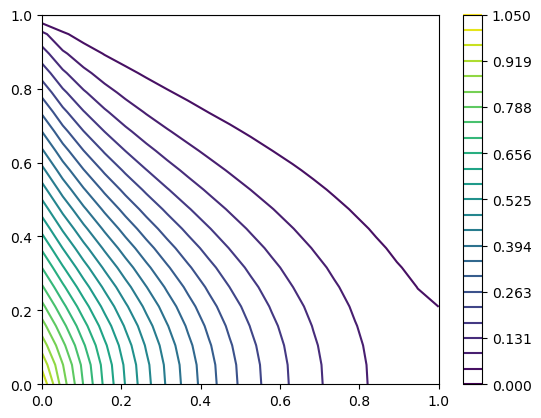

In [51]:
%matplotlib inline
dcs.FullyExplicit(tFinal = 0.7, ΔtScalingFactor = 0.95, plot = True)

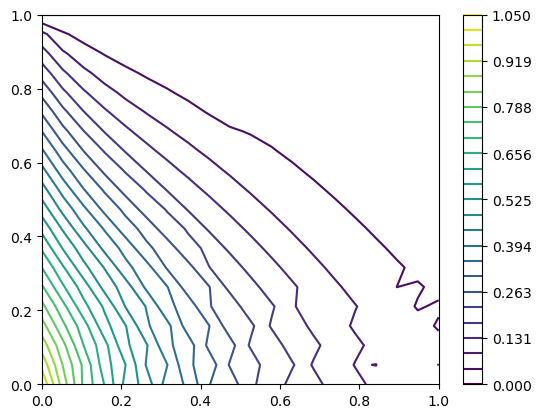

In [52]:
%matplotlib inline
dcs.FullyExplicit(tFinal = 0.7, ΔtScalingFactor = 1.05, plot = True)

## Part A

As we can see above, a time step smaller than the maximum results in a still converging solution using Fully-Explicit method, while a time step larger than the maximum leads to an answer which has just begun to diverge.

## Part D

Make contour plots for Crank-Nicolson case at $t = 0.2$, $t = 1.0$, and $t = 2.0$ seconds.

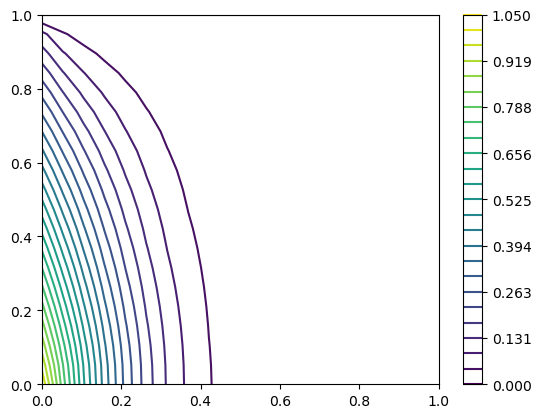

In [53]:
%matplotlib inline
dcs.SolveSpecifiedMethod(tFinal = 0.2, ε = 10e-5, plot = True)

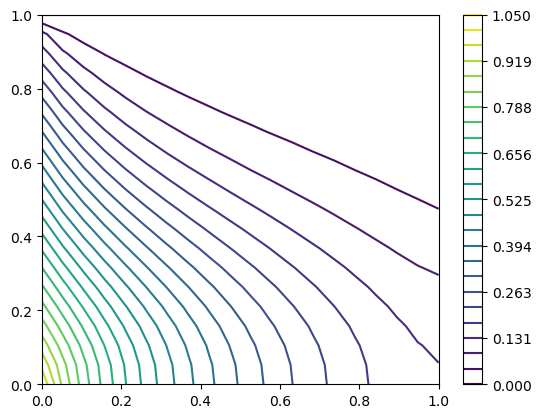

In [54]:
%matplotlib inline
dcs.SolveSpecifiedMethod(tFinal = 1.0, ε = 10e-5, plot = True)

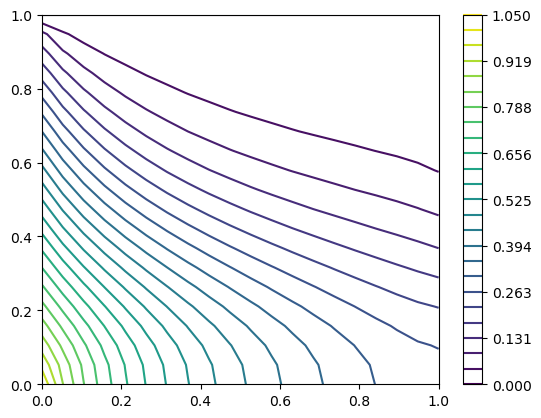

In [55]:
%matplotlib inline
dcs.SolveSpecifiedMethod(tFinal = 2.0, ε = 10e-5, plot = True)

Compare the plot at $t = 1.0$ with the results given by the FI and FE methods.

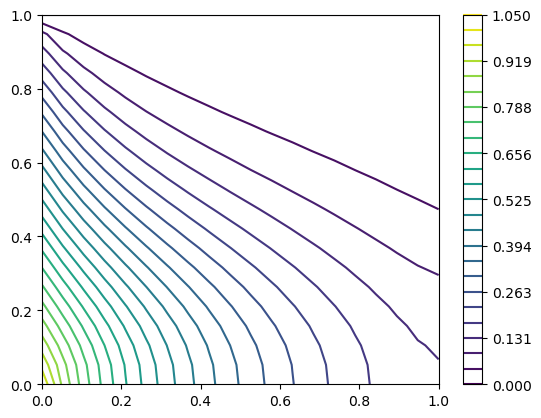

In [56]:
%matplotlib inline
dcs.FullyExplicit(tFinal = 1.0, ΔtScalingFactor = 1.0, plot = True)

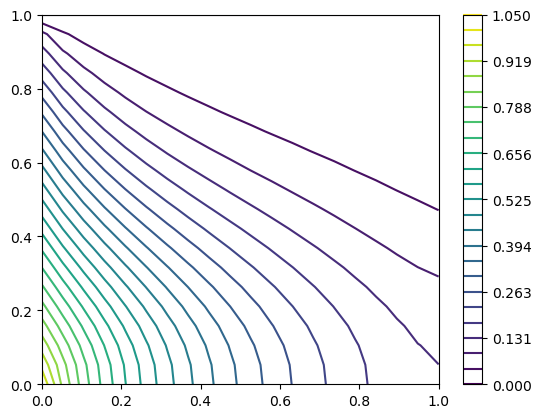

In [57]:
%matplotlib inline
dcs.FullyImplicit(tFinal = 1.0, ε = 10e-5, plot = True)

As shown above, there are hardly differences between the three methods as they all have converged very closely to the true answer. Since the time step and spacial steps are within the criteria we defined before for the Von Neumann stability analysis as applied to the Fully Explicit case, we can argue that the fully explicit result is the "correct answer" while the FI and CN methods offer approximated solutions. However, just looking at the contour plots above, the differences for our applications are negligible.

## Part E

Construct a final contour plot repeating the CN case for a grid size of 40 x 40 at $t = 2.0$. Comment on the results.

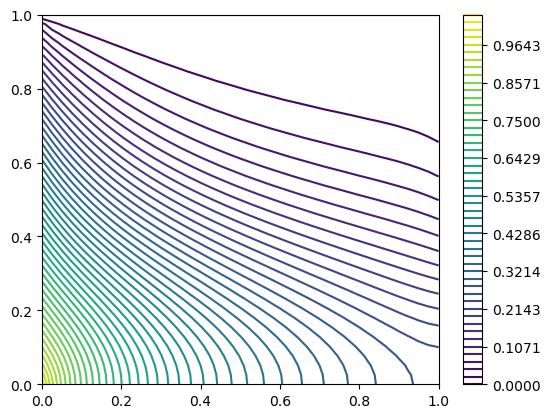

In [58]:
%matplotlib inline
# make a new dcs object with a 40 x 40 grid size instead of the 20 x 20 case
dcs = DiffusionCrossSection(nSpacial = 40, width = 1.0, height = 1.0, methodParameter = 1 / 2, resolution = 50)
# methodParameter is set to 1 / 2 again for crank-nicolson method to be used

# and the solution/contour plot is given by solving with the 'SolveSpecifiedMethod' method
dcs.SolveSpecifiedMethod(tFinal = 2.0, ε = 10e-5, plot = True)

### Comments for Part E

The contour plot above shows that the results for a finer grid size with more points has arguably the same outcome as the grid with only 400 points on it (20 x 20 case). Comparing this to the $t = 2.0$ case for CN method with a 20 x 20 grid shows almost no differences. However, by reading through some of the software above, it will become apparent that in fact the grid does have a higher resolution in which this grid size contains 1600 points on it. I have increased the resolution of the plot to show the smoothness of the contour lines, but the main difference between a larger grid size than 20 x 20 is the time it takes to converge to the solution with SOR method. There is arguably some higher resolution in this solution, but the computer time it consumes as compared to the less resolved 20 x 20 case is potentially not worth it. All in all, this has been an excellent project and has taught me a ton about the Crank-Nicolson, Fully Explicit, and Fully Implicit methods and has demonstrated their strengths to me in various ways. I plan to use these skills for my future software adventures and am pleased by the result from all the hard work it took to get here.